In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import plotly.express as px
from tqdm import tqdm
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
import torchvision.datasets as datasets  
from torch.utils.data import DataLoader  
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor

/shared-libs/python3.10/py/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Model Definition

In [3]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim * 2)  # Two outputs for mean and variance
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Sigmoid()  # Output values between 0 and 1
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = x.view(x.size(0), -1)
        latent_params = self.encoder(x)
        mu = latent_params[:, :latent_dim]
        log_var = latent_params[:, latent_dim:]
        z = self.reparameterize(mu, log_var)
        reconstructed = self.decoder(z)
        return reconstructed, mu, log_var


### Select device

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Load Model

In [7]:
checkpoint_path = 'vae_checkpoint.pth'
checkpoint = torch.load(checkpoint_path,map_location=torch.device('cpu'))
latent_dim = checkpoint['latent_dim']
model = VAE(latent_dim)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [9]:
model.eval()

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=40, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

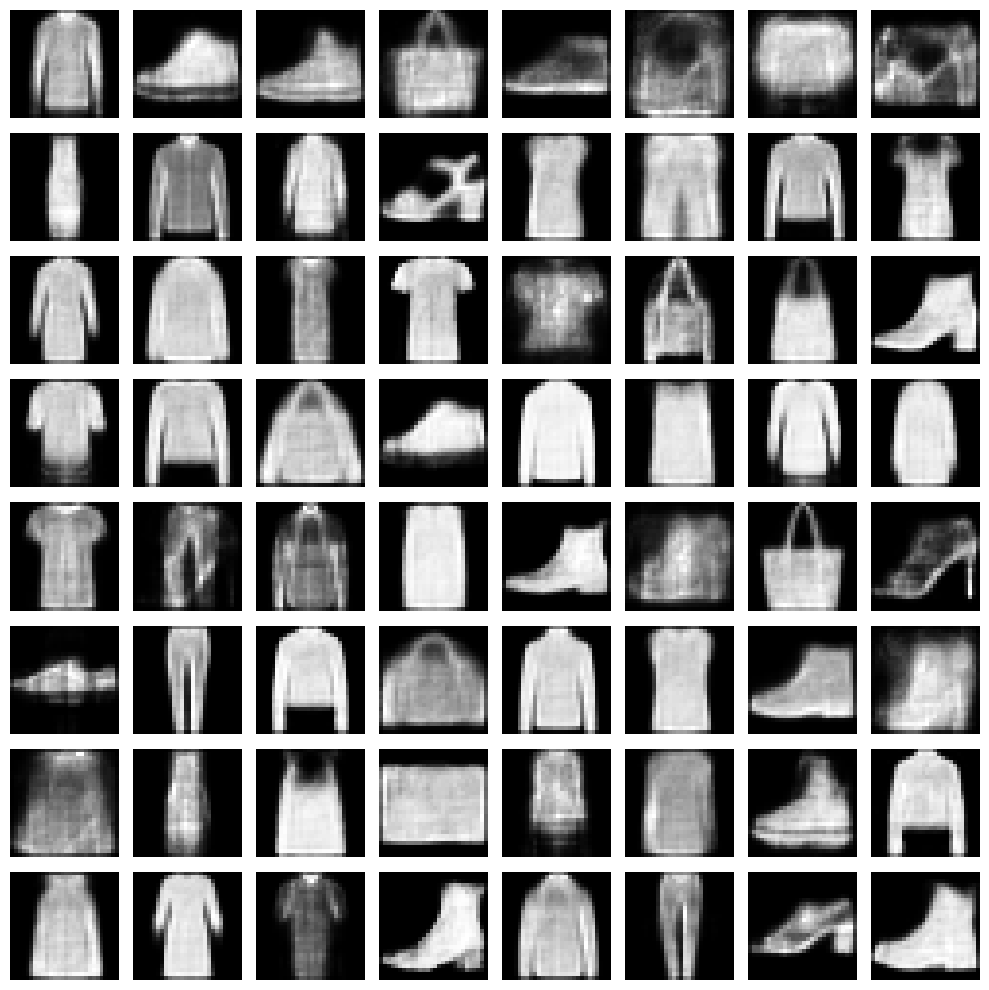

In [11]:
# Generate latent vectors
num_images = 64

latent_vectors = torch.randn(num_images, latent_dim).to("cpu")

# Reconstruct images
with torch.no_grad():
    reconstructed_images = model.decoder(latent_vectors)

# Reshape the reconstructed images to the original shape
reconstructed_images = reconstructed_images.view(-1, 1, 28, 28)

# Convert the tensor to numpy array
reconstructed_images = reconstructed_images.cpu().numpy()

# Plot the reconstructed images
fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(reconstructed_images[i][0], cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=dcae6c14-c366-4bf6-8d3d-fc998b9feae8' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>